<a href="https://colab.research.google.com/github/saurabhgupta18891/Documents-Text--Classification-and-Clustering/blob/master/Multi_Class_Text_Classification_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install cufflinks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# New Section

In [ ]:
#train_raw = pd.read_csv(r'C:\Users\Saurabh\OneDrive - R Systems International Ltd\Desktop\Text-Classification\rows.csv\consumer_complaints.csv')
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_raw=pd.read_csv('/content/gdrive/MyDrive/consumer_complaints.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df=train_raw.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282355 entries, 0 to 1282354
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1282355 non-null  object
 1   Product                       1282355 non-null  object
 2   Sub-product                   1047189 non-null  object
 3   Issue                         1282355 non-null  object
 4   Sub-issue                     751169 non-null   object
 5   Consumer complaint narrative  383564 non-null   object
 6   Company public response       449082 non-null   object
 7   Company                       1282355 non-null  object
 8   State                         1262955 non-null  object
 9   ZIP code                      1167057 non-null  object
 10  Tags                          175643 non-null   object
 11  Consumer consent provided?    690654 non-null   object
 12  Submitted via                 1282355 non-

In [ ]:
df = df[train_raw["Consumer complaint narrative"].notnull()]
df.shape

(383564, 18)

In [ ]:
df['len_txt'] =df["Consumer complaint narrative"].astype(str).apply(lambda x: len(x.split()))
df.describe()

,Complaint ID,len_txt
count,3.835640e+05,383564.000000
mean,2.440054e+06,196.822382
std,5.316289e+05,211.063970
min,1.290155e+06,1.000000
25%,2.027031e+06,71.000000
50%,2.580564e+06,136.000000
75%,2.881326e+06,249.000000
max,3.189109e+06,6314.000000


In [ ]:
df = df[df.len_txt >249]
df.shape

(95534, 19)

In [ ]:
df.Product.value_counts()

Mortgage                                                                        22713
Debt collection                                                                 15530
Credit reporting, credit repair services, or other personal consumer reports    14767
Student loan                                                                     7125
Credit card or prepaid card                                                      7059
Credit card                                                                      5525
Bank account or service                                                          5046
Checking or savings account                                                      4573
Credit reporting                                                                 4403
Consumer Loan                                                                    2802
Vehicle loan or lease                                                            2091
Money transfer, virtual currency, or money service    

In [ ]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [ ]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [ ]:
df["Product"].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Credit card or prepaid card', 'Mortgage',
       'Checking or savings account', 'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service',
       'Student loan', 'Payday loan, title loan, or personal loan',
       'Bank account or service', 'Consumer Loan', 'Prepaid card',
       'Money transfers'], dtype=object)

In [ ]:
df.isnull().sum()

Date received                       0
Product                             0
Sub-product                     10181
Issue                               0
Sub-issue                       40302
Consumer complaint narrative        0
Company public response         50118
Company                             0
State                             378
ZIP code                        22697
Tags                            77227
Consumer consent provided?          0
Submitted via                       0
Date sent to company                0
Company response to consumer        3
Timely response?                    0
Consumer disputed?              53372
Complaint ID                        0
len_txt                             0
dtype: int64

In [ ]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [ ]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

In [ ]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

<ipython-input-19-40704303c81a>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
print_plot(10)

associate came home florida installed home security system home problems beginning bills always satisfied paid timely manner major storm hit area lighting struck home burned system made numerous phone calls system repaired replaced nobody ever came make repairs replace system called many times appointments supposed scheduled nobody would show checked credit report saw sold account third party collection agency called perfection collection gave perfection collection call eplain didnt owe bill broke contract someone come home fi replace system major storm lighting strike burning system collection agent stated dont care want hear state must pay bill today contact figure mess tried communicate perfection collection successful called eplain happened option gave call perfection collection account sold nothing anyone could assist owe perfection collection total amount  services never provided amount owed began major storm occured lighting strike home burned unit amount owed time im asking rem

In [ ]:
print_plot(100)

take school financial purposed spring semester full intention getting back classes fall semester however loan deferment period end oaf school long skipped fall semester try get hours work could try pay back looking lowering payments month month able file income driven payments federal loans payments went  make    year helped however try solve problem balance  options trying solve problem informed options available lower payments instead try see family members friends borrow money make payments telling option option time pay  doesnt get applied balance duethis payment stop harassment  phone calls day emails father cosigner agreed however asked amount get taken following day could move money account net step would pay amount  net day attempted take  account payment didnt go didnt much account time happen phone calls emails started right back father got email stating account brought date going report consumers reporting agencies father reported paid amount need get enrolled school least h

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 104583 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (95435, 250)


In [ ]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (95435, 13)


In [ ]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# train, validate, test = np.split(X.sample(frac=1, random_state=42), 
#                        [int(.8*len(X)), int(.9*len(X))])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(85891, 250) (85891, 13)
(9544, 250) (9544, 13)


In [ ]:
 X_train , X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.10, random_state=1)

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(77301, 250) (77301, 13)
(8590, 250) (8590, 13)


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote,y_smote = oversample.fit_resample(X_train,Y_train)
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

In [ ]:
X_smote.shape

(240136, 250)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
class attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(attention(return_sequences=False)) # receive 3D and output 3D
#model.add(LSTM(32))
model.add(Dense(13, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 250, 100)         60400     
 nal)                                                            
                                                                 
 attention_3 (attention)     (None, 100)               350       
                                                                 
 dense_3 (Dense)             (None, 13)                1313      
                                                                 
Total params: 5,062,063
Trainable params: 5,062,063
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
2175/2175 [==============================] - 50s 23ms/step - loss: 0.6379 - accuracy: 0.7824 - val_loss: 0.6735 - val_accuracy: 0.7723
Epoch 2/10
2175/2175 [==============================] - 50s 23ms/step - loss: 0.5246 - accuracy: 0.8132 - val_loss: 0.6333 - val_accuracy: 0.7841
Epoch 3/10
2175/2175 [==============================] - 50s 23ms/step - loss: 0.4514 - accuracy: 0.8372 - val_loss: 0.6285 - val_accuracy: 0.7857
Epoch 4/10
2175/2175 [==============================] - 50s 23ms/step - loss: 0.3811 - accuracy: 0.8614 - val_loss: 0.6485 - val_accuracy: 0.7867
Epoch 5/10
2175/2175 [==============================] - 50s 23ms/step - loss: 0.3208 - accuracy: 0.8862 - val_loss: 0.6676 - val_accuracy: 0.7859
Epoch 6/10
2175/2175 [==============================] - 51s 23ms/step - loss: 0.2502 - accuracy: 0.9133 - val_loss: 0.7336 - val_accuracy: 0.7868


In [ ]:
# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(13, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 13)                1313      
                                                                 
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.models import load_model

In [ ]:
model.save_weights("/content/gdrive/MyDrive/Colab Notebooks/textClassification_Bilstm.h5")
# # loaded_model = load_model("network.h5")
# loss, accuracy = loaded_model.evaluate(test_data, test_targets)


In [ ]:
loaded_model = model.load_weights("/content/gdrive/MyDrive/Colab Notebooks/textClassification_Bilstm.h5")
#loss, accuracy = loaded_model.evaluate(X_test, Y_test)

In [ ]:
accr = model.evaluate(X_val, Y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

299/299 [==============================] - 3s 11ms/step - loss: 0.7203 - accuracy: 0.7922
Test set
  Loss: 0.720
  Accuracy: 0.792


In [ ]:
Y_pred=model.predict(X_test)

269/269 [==============================] - 4s 10ms/step


In [ ]:
!pip install keras-metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from tensorflow.keras import backend as K

# def f1(y_true, y_pred):    
#     def recall_m(y_true, y_pred):
#         TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
#         recall = TP / (Positives+K.epsilon())    
#         return recall 
    
    
#     def precision_m(y_true, y_pred):
#         TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
#         precision = TP / (Pred_Positives+K.epsilon())
#         return precision 
    
#     precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# import tensorflow as tf
# # Y_pred = tf.bitcast(Y_pred, tf.uint8)
# # Y_val= tf.bitcast(Y_val, tf.uint8)
# Y_pred1=tf.bitcast(tf.cast(Y_pred, tf.int8), tf.uint8)
# Y_val1=tf.bitcast(tf.cast(Y_val, tf.int8), tf.uint8)
# #tf.cast(image, tf.uint8)

In [ ]:
predictions = np.argmax(Y_pred,axis=1)

In [ ]:
Y_true=np.argmax(Y_test,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
#from keras import metrics
matrix = confusion_matrix(Y_true, predictions)
matrix

array([[  97,  262,    7,   50,    8,   18,    8,    0,   21,    1,    0,
           1,    0],
       [  95,  265,    3,   31,    2,    7,    2,    0,    6,    1,    0,
           1,    0],
       [   0,    5,  105,    8,   21,   35,    2,    0,    9,    4,    0,
          13,   15],
       [  34,   65,   12,  926,   53,   47,    5,    0,   11,    0,    0,
           2,    1],
       [   3,    2,   44,   53, 1362,  134,    0,    0,   55,    2,    0,
          34,    5],
       [   5,   12,   35,   37,   72, 1161,    1,    0,   50,    2,    0,
          31,    1],
       [  15,  103,    1,    7,    1,    4,   19,    0,    4,    0,    0,
           1,    0],
       [   4,   31,    0,    3,    1,    0,    7,    0,    0,    0,    0,
           0,    1],
       [   7,    3,    5,   10,   20,   25,    0,    0, 1909,    1,    0,
           3,    0],
       [   2,    2,   26,    6,    4,   33,    3,    0,    8,    8,    0,
          26,    1],
       [   1,   12,    0,   18,    0,    0,    0, 

In [ ]:
Y_true

array([5, 3, 3, ..., 2, 1, 4])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

labels=Y_true
predictions=predictions
# Compute evaluation metrics
acc = accuracy_score(labels, predictions)
prec = precision_score(labels, predictions, average='weighted')
rec = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)


Accuracy:  0.7953434225844005
Precision:  0.7943288504917398
Recall:  0.7953434225844005
F1-score:  0.7937341348859348


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels, predictions,target_names=None))


              precision    recall  f1-score   support

           0       0.49      0.55      0.52       473
           1       0.60      0.49      0.54       413
           2       0.41      0.42      0.42       217
           3       0.77      0.85      0.81      1156
           4       0.85      0.87      0.86      1694
           5       0.80      0.79      0.80      1407
           6       0.61      0.66      0.64       155
           7       0.26      0.11      0.15        47
           8       0.95      0.93      0.94      1983
           9       0.48      0.46      0.47       119
          10       0.50      0.47      0.48        32
          11       0.92      0.89      0.90       690
          12       0.51      0.40      0.45       204

    accuracy                           0.80      8590
   macro avg       0.63      0.61      0.61      8590
weighted avg       0.79      0.80      0.79      8590



<Figure size 1080x576 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix \n')

Text(0.5, 51.0, '\n Predicted Values\n')

Text(114.0, 0.5, 'Actual Values\n')

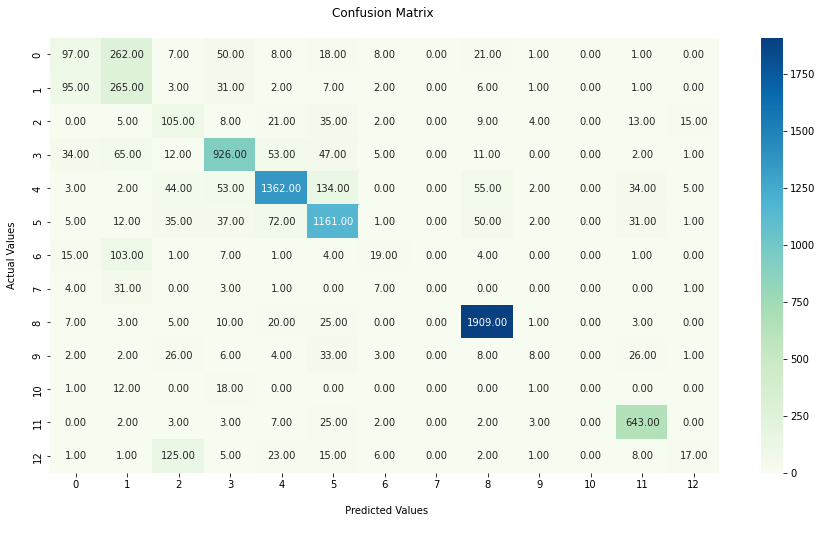

In [ ]:
plt.figure(figsize=(15,8))
fx=sns.heatmap(confusion_matrix(labels, predictions), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
plt.show()

Test with a new complaint.

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 396ms/step
[[7.0015952e-02 4.4611890e-02 3.2800499e-03 8.3944780e-01 1.5010656e-02
  3.1695960e-03 6.0808579e-03 1.6337994e-03 1.9261136e-03 2.1537552e-03
  1.0583194e-02 2.0077915e-04 1.8854496e-03]] Credit card or prepaid card
